# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning 👷‍♂️

In this notebook, I'll be exploring the goal of predicting an auction sale price for a piece of heavy equipment to create a "blue book" for bulldozers. The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration.  The data is sourced from auction result postings and includes information on usage and equipment configurations.

Fast Iron is creating a "blue book for bull dozers," for customers to value what their heavy equipment fleet is worth at auction.

## 1. Problem definition

> How well can a prediction be made on the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers were sold for?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
# Import training and validation sets
# Working with time series data, we want to enrich the time & date component as much as possible. This can be enabled by commanding the date columns to be parsed (conversion to a datetime datatype) using  `parse_dates` parameter.

df = pd.read_csv("data/TrainAndValid.csv",  
                 low_memory=False,
                 parse_dates=['saledate'])

In [3]:
df.sample(5)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
229531,1721601,37000.0,1193288,2160,132,8.0,2003,NaN,NaN,2010-07-21,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
54658,1301894,27000.0,1524255,4123,132,99.0,1976,NaN,NaN,2001-10-12,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
146930,1518795,38000.0,1523970,1564,132,1.0,1986,NaN,NaN,1993-11-16,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
290009,2207519,22000.0,1551041,3171,136,1.0,1000,0.0,NaN,2009-06-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411997,6315055,21000.0,1796379,17429,149,99.0,2004,NaN,NaN,2012-03-13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [5]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [6]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

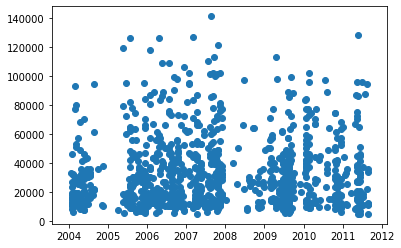

In [7]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);


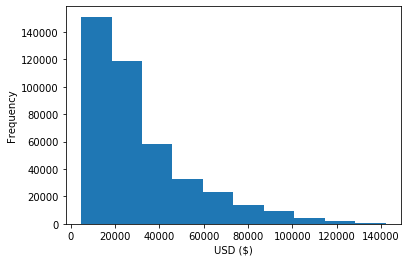

In [8]:
df.SalePrice.plot.hist()
plt.xlabel('USD ($)');

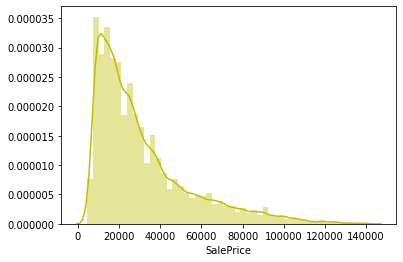

In [9]:
sns.distplot(df['SalePrice'], color="y");

### Sort DataFrame by saledate column

Working with time series data, it's a good idea to sort it by date.

In [10]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [11]:
df.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


### Add datetime parameters for `saledate` column

In [12]:
df["saleYear"] = df.saledate.dt.year
df["saleMonth"] = df.saledate.dt.month
df["saleDay"] = df.saledate.dt.day
df["saleDayOfWeek"] = df.saledate.dt.dayofweek
df["saleDayOfYear"] = df.saledate.dt.dayofyear


In [13]:
# After enriching the DataFrame with date time features, let's remove the original 'saledate' column
df.drop("saledate", axis=1, inplace=True)

### 💾 Checkpoint 1 - Make a copy of sorted and parsed dates DataFrame 

Following changes to `saledate` and adding datetime parameters. Making a copy of the original dataframe to keep raw data intact.

In [14]:
# Make a copy of the original DataFrame to perform edits on
df1 = df.copy()
df1.to_csv("data/df1.csv")

In [15]:
# Check the values of different columns
df1.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [16]:
df1.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


## 5. Cleaning the Data in Preparation for Data Modelling 🤦🏼‍♂️
    
*   Convert strings to categorical features (i.e. numerical)
*    Fill missing values
        1. All of the data has to be numerical for the M.L. models to process
        2. There can't be any missing values
            - Categorical columns (binary/numerical padding)
            - Numerical columns (impute with median values)


List of ALL columns with missing data

In [17]:
df1.isna().sum,
[col for col in df1.columns if df1[col].isnull().any()]

['auctioneerID',
 'MachineHoursCurrentMeter',
 'UsageBand',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Hydraulics',
 'Pushblock',
 'Ripper',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls']

🔍 Check which columns contain strings.

We can see using `df1.isna().sum()` the data has plenty of missing values that will need to be addressed before the modeling stage. 

In [18]:
# These columns contain strings - a DataFrame consists of keys (Columns) and values
for label, content in df1.items():  #label (column), content (values)
    if pd.api.types.is_string_dtype(content):
        print(label)
        
        # returns all columns in 'string' datatype

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


✅ Convert the list of string values into categorical (numerical) 

In [19]:
# This will turn all of the string values into category values
for label, content in df1.items():
    if pd.api.types.is_string_dtype(content):
        df1[label] = content.astype("category").cat.as_ordered()

In [20]:
# Under the hood, Python now treats previously 'string' data as categories
df1.UsageBand.cat.codes, df1.state.cat.codes

(205615   -1
 274835   -1
 141296   -1
 212552   -1
 62755    -1
          ..
 410879   -1
 412476   -1
 411927   -1
 407124   -1
 409203   -1
 Length: 412698, dtype: int8,
 205615    43
 274835     8
 141296     8
 212552     8
 62755      8
           ..
 410879     4
 412476     4
 411927     4
 407124     4
 409203     4
 Length: 412698, dtype: int8)

In [21]:
# All (categorical + numerical) missing data in terms of percentages
df1.isnull().sum()/len(df1)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

✅ Categorical columns (binary/numerical padding)

In [22]:
# Check columns which *aren't* numeric
for label, content in df1.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [23]:
# Turn categorical variables into numbers
for label, content in df1.items():
    # Check columns which *aren't* numeric
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to inidicate whether sample had missing value
        # fills values previously "is missing" with a 0
        df1[label+"_is_missing"] = pd.isnull(content)
        # We add the +1 because pandas encodes missing categories as -1
        df1[label] = pd.Categorical(content).codes+1        

In [24]:
df1.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [25]:
df1.isna().sum()[:20]

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                        0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc                  0
fiModelSeries                    0
fiModelDescriptor                0
ProductSize                      0
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                     0
dtype: int64

In [26]:
# Check columns which *aren't* numeric
for label, content in df1.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(df1.isna().sum())

✅ Filled Categorical columns (binary/numerical padding)

### 💾 Checkpoint 2 - Make a copy following filled categorical columns 

... Let's now look to fill missing values in numerical columns with the median values.

In [27]:
# Make a copy of the original DataFrame to perform edits on
df2 = df1.copy()
df2.to_csv("data/df2.csv")

In [28]:
# List of numerical columns 
for label, content in df2.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear
UsageBand_is_missing
fiModelDesc_is_missing
fiBaseModel_is_missing
fiSecondaryDesc_is_missing
fiModelSeries_is_missing
fiModelDescriptor_is_missing
ProductSize_is_missing
fiProductClassDesc_is_missing
state_is_missing
ProductGroup_is_missing
ProductGroupDesc_is_missing
Drive_Syste

In [29]:
# Check for which numeric columns have null values
for label, content in df2.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [30]:
# Fill numeric rows with the median
for label, content in df2.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells if the data was missing our not
            df2[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median since it's more robust than the mean
            df2[label] = content.fillna(content.median())

Why add a binary column indicating whether the data was missing or not?

> We can easily fill all of the missing numeric values in our dataset with the median. However, a numeric value may be missing for a reason. Adding a binary column which indicates whether the value was missing or not helps to retain this information. I also chose filling missing numerical values with the median over mean due its robustness against outliers. For example, if values in either of the numerical columns ['auctioneerID'], ['MachineHoursCurrentMeter] contained extremely high/low values (outliers), the mean value could become heavily skewed. The median would still retain relative value for imputation in this regard.

In [31]:
# Check if there's any null values - Sanity Check
for label, content in df2.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)
# if there's still any numeric columns with null values in them 
# it should print out those column names

No columns were printed thus all Nan (missing) values have been sufficiently filled. Let's identify how many null numerical values were replaced by the `median()`.

In [32]:
# Check to see how many examples were missing
df2.auctioneerID_is_missing.value_counts()

# means it filled out 20,136 previously null columns with median

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

✅ Fill missing values in all numerical columns (impute with median values)

♻️ All missing values (categorical + numerical) should now be adequately identified and filled. 

In [33]:
df2.isna().sum()

SalesID                                0
SalePrice                              0
MachineID                              0
ModelID                                0
datasource                             0
                                      ..
Travel_Controls_is_missing             0
Differential_Type_is_missing           0
Steering_Controls_is_missing           0
auctioneerID_is_missing                0
MachineHoursCurrentMeter_is_missing    0
Length: 103, dtype: int64

### 🔐 Checkpoint  3 - copy of data following data preparation and prior to data modelling stage.

In [34]:
# Make a copy of the original DataFrame to perform edits on
df3 = df2.copy()
df3.to_csv("data/df3.csv")

## 6. Modelling 

All of the data is now numeric without missing values. Knowing that this is a regression problem, I like to initiate the modeling stage with [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), so we will need to split the data into training, validation, and test samples according to the date, since this a time-series problem. 

According to the [Kaggle data page](https://www.kaggle.com/c/bluebook-for-bulldozers/data), the validation set and test set are split according to dates (E.g. using past events to try and predict future events.)

In this case:

*   Training = all samples up until 2011
*   Valid = all samples form January 1, 2012 - April 30, 2012
*   Test = all samples from May 1, 2012 - November 2012


For more on making good training, validation and test sets, check out the post [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/) by Rachel Thomas.

In [35]:
df3.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [36]:
# Split data into training and validation
df_val = df3[df3.saleYear == 2012]
df_train = df3[df3.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [37]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

Instantiate the intial model, `RandomForestRegressor`. Due to the amount of data, processing time, and upcoming hyperparameter tuning,I'll be setting `max_samples` to 10,000 meaning every `n_estimator` (default 100) in `RandomForestRegressor` will only see 10,000 random samples from the DataFrame instead of the entire 401,125. This way, the model will be evaluating 40x less samples which drastically increases computation speeds but due to limiting the amount of samples the model will be learning from it should be expected the results won't be optimal to start.       

In [38]:
%%time 
from sklearn.ensemble import RandomForestRegressor

# Instantiate model
model = RandomForestRegressor(n_jobs=-1, max_samples=10000)

# Fit the model
model.fit(X_train, y_train)

Wall time: 7.46 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=10000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### Building an evaluation function

According to Kaggle for the Bluebook for Bulldozers competition, [the evaluation function](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation) they use is root mean squared log error (RMSLE).

**RMSLE** = generally you don't care as much if you're off by $10 as much as you'd care if you were off by 10%, you care more about ratios rather than differences. **MAE** (mean absolute error) is more about exact differences.

I'll be taking the square root of Scikit-Learn's [mean_squared_log_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error) (MSLE). 

In [39]:
# Create evaluation function (Root Mean Square Log Error)
from sklearn.metrics import mean_squared_log_error, r2_score, mean_absolute_error

def rmsle(y_test, y_preds):  #(y_true, y_preds)
    """
    Calculates root mean squared log error between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate our model against coefficient of determination, MAE, and Kaggle metric
def show_scores(model):
    """
    Evaluate how model does on training and validation data.
    """
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid) #model performing better on validation = overfitting
    scores = {"Training MAE": round(mean_absolute_error(y_train, train_preds),5),
              "Valid MAE": round(mean_absolute_error(y_valid, val_preds),5),
              "Training RMSLE": round(rmsle(y_train, train_preds),5),
              "Valid RMSLE": round(rmsle(y_valid, val_preds),5),
              "Training R^2": round(r2_score(y_train, train_preds),5),
              "Valid R^2": round(r2_score(y_valid, val_preds),5)}
    return scores

In [40]:
show_scores(model)

{'Training MAE': 5557.60597,
 'Valid MAE': 7137.24276,
 'Training RMSLE': 0.25732,
 'Valid RMSLE': 0.29244,
 'Training R^2': 0.86052,
 'Valid R^2': 0.83382}

### Hyerparameter tuning with RandomizedSearchCV

In [41]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                                                    param_distributions=rf_grid,
                                                    n_iter=2,
                                                    cv=5,
                                                    verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   48.1s finished


Wall time: 52.2 s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [42]:
# Find the best model hyperparameters
rs_model.best_params_
rs_model.best_score_

0.749304052315131

In [43]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 5768.4063,
 'Valid MAE': 7275.1536,
 'Training RMSLE': 0.26528,
 'Valid RMSLE': 0.29909,
 'Training R^2': 0.85229,
 'Valid R^2': 0.83276}

### Train a model with the best hyperparamters

**Note:** These were found after 100 iterations of `RandomizedSearchCV`.

In [44]:
%%time

# Ideal hyperparamters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42) # random state so our results are reproducible

# Fit the ideal model
ideal_model.fit(X_train, y_train)

Wall time: 35.1 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=14, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [45]:
# Scores for ideal_model (trained on all the data)
show_scores(ideal_model)

{'Training MAE': 2958.52569,
 'Valid MAE': 5960.08061,
 'Training RMSLE': 0.14485,
 'Valid RMSLE': 0.24692,
 'Training R^2': 0.95871,
 'Valid R^2': 0.88117}

In [46]:
# Scores on rs_model (only trained on ~10,000 examples)
show_scores(rs_model)

{'Training MAE': 5768.4063,
 'Valid MAE': 7275.1536,
 'Training RMSLE': 0.26528,
 'Valid RMSLE': 0.29909,
 'Training R^2': 0.85229,
 'Valid R^2': 0.83276}

In [47]:
# Scores on ititial `RandomForestRegressor()` model
show_scores(model)

{'Training MAE': 5557.60597,
 'Valid MAE': 7137.24276,
 'Training RMSLE': 0.25732,
 'Valid RMSLE': 0.29244,
 'Training R^2': 0.86052,
 'Valid R^2': 0.83382}

| <img src="images/xgboost.png" width=500/> | 
|:--:| 
| XGBoost ([read more](https://heartbeat.fritz.ai/boosting-your-machine-learning-models-using-xgboost-d2cabb3e948f)) |


`XGBoost` has become a widely used and really popular tool among Kaggle competitors and Data Scientists in industry, as it has been battle tested for production on large-scale problems. It is a highly flexible and versatile tool that can work through most regression, classification and ranking problems as well as user-built objective functions.

In [48]:
# %%time 
# from xgboost.sklearn import XGBRegressor


# # Instantiate model
# xg_reg = xgb.XGBRegressor(nthreads=-1, random_state=42,learning_rate=0.15)

# # Fit the model
# xg_reg.fit(X_train, y_train)

In [49]:
%%time
from xgboost.sklearn import XGBRegressor  
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

# Different XgBoost hyperparameters
rf_grid = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": st.beta(10, 1),
    "subsample": st.beta(10, 1),
    "gamma": st.uniform(0, 10),
    'reg_alpha': st.expon(0, 50),
    "min_child_weight": st.expon(0, 50),
}

# Instantiate RandomizedSearchCV model
xg_boost = RandomizedSearchCV(XGBRegressor(n_jobs=-1,
                                           random_state=42),
                                           param_distributions=rf_grid,
                                           n_iter=2,
                                           cv=5,
                                           verbose=True)

# Fit the RandomizedSearchCV model
xg_boost.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  9.6min finished


Wall time: 10min 21s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F7A8CEBA00>,
                                        'reg_alpha': <scip

In [50]:
# show_scores(xg_boost)
xg_param = xg_boost.best_params_
print(xg_param)


{'colsample_bytree': 0.9226950656351158, 'gamma': 9.597376189226045, 'learning_rate': 0.18681704362493778, 'max_depth': 22, 'min_child_weight': 120.9939130525831, 'n_estimators': 22, 'reg_alpha': 40.368422814383315, 'subsample': 0.9737318054084824}


In [51]:
xg_boost.best_score_

0.7921212097294048

In [52]:
%%time

# Most ideal hyperparamters
best_params_grid = xg_param

xgb_ideal = XGBRegressor(n_jobs=-1,
                         param_distributions=best_params_grid,
                         n_iter=2,
                         cv=2,
                         verbose=True,
                         random_state=42) # for reproducible results

# Fit the ideal model
xgb_ideal.fit(X_train, y_train)

Wall time: 1min 3s


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, cv=2, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_iter=2, n_jobs=-1, num_parallel_tree=1,
             objectiv...
             param_distributions={'colsample_bytree': 0.9226950656351158,
                                  'gamma': 9.597376189226045,
                                  'learning_rate': 0.18681704362493778,
                                  'max_depth': 22,
                                  'min_child_weight': 120.9939130525831,
                                  'n_estimators': 22,
                                  'reg_alpha': 40.368422814383315,
                                  'subsample': 0.9737318054084824},
             random_state=4

Comparing the evaluation metrics for `RandomForestRegressor()` and the `XgBoost()` models as it stands, they're quite comparable. Specifically the __'Valid RMSLE'__ -Kaggle scoring metric. The XgBoost given ideal hyperparameters should outperform most models. In this case, either model is suitable given the accuracy measures and the bulldozer price prediction definition problem. With a __'Valid RMSLE' : 0.24692__, the model scores in the top 30 leaderboard rank and in the 93.5 percentile. 

In [53]:
# Scores for ideal_model
show_scores(ideal_model)

{'Training MAE': 2958.52569,
 'Valid MAE': 5960.08061,
 'Training RMSLE': 0.14485,
 'Valid RMSLE': 0.24692,
 'Training R^2': 0.95871,
 'Valid R^2': 0.88117}

In [72]:
# Scores on xgboost_model 
show_scores(xg_boost)

{'Training MAE': 4168.10455,
 'Valid MAE': 6083.86937,
 'Training RMSLE': 0.1987,
 'Valid RMSLE': 0.25044,
 'Training R^2': 0.9175,
 'Valid R^2': 0.87363}

## Make predictions on test data

In [74]:
# Import the test data
df_test = pd.read_csv("data/Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])

df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


### Preprocessing the data (getting the test dataset in the same format as our training dataset)

In [56]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
        # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [57]:
# Process the test data 
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [58]:
# Make predictions on updated test data- Received: ValueError: Number of features of the model 
# must match the input. Model n_features is 102 and input n_features is 101 


# test_preds = ideal_model.predict(df_test)

In [59]:
# \ find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [60]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


💣 The test and train DataFrames are now similarly matching in features, predictions on the test set can be made. 

In [61]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)

In [62]:
test_preds

array([17699.40283986, 15323.48268964, 51178.31732513, ...,
       13646.28034948, 18972.42792312, 25595.19590287])

Predictions look good but they're not in the same format Kaggle is asking for: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [63]:
# Format predictions into the Kaggle format
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,17699.402840
1,1227844,15323.482690
2,1227847,51178.317325
3,1227848,62016.373917
4,1227863,47597.489432
...,...,...
12452,6643171,42311.831644
12453,6643173,14918.293669
12454,6643184,13646.280349
12455,6643186,18972.427923


In [64]:
# Export prediction data for Kaggle submission
df_preds.to_csv("data/test_predictions.csv", index=False)

In [75]:
import pickle

# Save the ideal_model `RandomForestRegressor` model to file
pickle.dump(ideal_model, open("rs_RandomForestRegressor.pkl", "wb"))



### Feature Importance

Feature importance seeks to figure out which different attributes of the data were most importance when it comes to predicting the **target variable** (SalePrice).

In [66]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.51586239e-02, 1.97748915e-02, 4.27606681e-02, 1.90613314e-03,
       3.27463962e-03, 2.00566731e-01, 3.22413890e-03, 9.85267576e-04,
       4.18931247e-02, 4.12083250e-02, 5.85903765e-02, 5.03002146e-03,
       1.67465985e-02, 1.35160647e-01, 4.78636632e-02, 5.92562512e-03,
       6.14735201e-03, 2.85439154e-03, 2.52573440e-03, 7.88450568e-02,
       4.21322981e-04, 5.24705610e-05, 1.50466818e-03, 1.87321771e-04,
       1.60328985e-03, 2.33144276e-05, 6.08490143e-03, 4.24131965e-03,
       2.29797041e-03, 2.97001329e-04, 2.17585157e-03, 1.63181193e-03,
       3.43030065e-03, 5.21618040e-04, 2.76700679e-04, 1.11879269e-02,
       8.16204101e-04, 1.44301025e-02, 1.94922078e-03, 1.35713882e-03,
       8.54963616e-04, 8.40145068e-04, 1.17918748e-03, 5.59509850e-04,
       5.79062374e-04, 3.59684011e-04, 2.72938291e-04, 2.41085143e-03,
       8.67104315e-04, 2.33938693e-04, 1.54600792e-04, 7.38865439e-02,
       3.71810242e-03, 5.68797343e-03, 2.91434259e-03, 9.91372727e-03,
      

In [67]:

# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

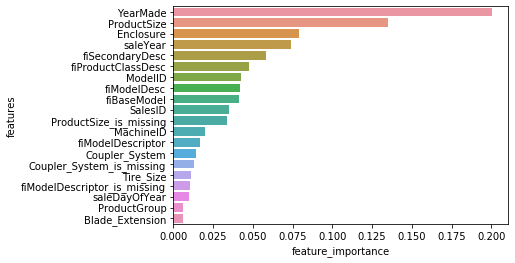

In [68]:
plot_features(X_train.columns, ideal_model.feature_importances_)

The two features that stand out are `YearMade` and `ProductSize`. I would ask the subject matter experts of the company if those features made sense for deriving predictions or the company could select these features to drive future production. 

**Conclusive notes:** Why might knowing the feature importances of a trained machine learning model be helpful? By gaining a better understanding of the model's logic the model can be improved by verifying and focusing only on the important variables. Discussing details and intricacies of the production year and size (`YearMade` and `ProductSize`) with management and industry experts could lead to breakthroughs and changes in production analysis, or at the least, to advice monitoring the variables as time passes. The rewards of this project was working with the challenges of uncleaned data or getting the data ready for modelling. Though I spent a great deal of time fixating on hyperparameter tuning, I am beginning to understand the correlation between model performance and data preparation. Iteratively I would like to fine-tune the XgBoost parameters to see how much the accuracy can be improved.  